In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
# df = pd.read_csv('exp1_res.csv').drop_duplicates()
df = pd.read_csv('exper1_results.csv').drop_duplicates()

In [122]:
df.shape

(3926, 7)

In [123]:
df.tail()

,Acc,NDCG,LL,RMSE,Mask,Tag,fname
3921,0.238108,0.380490,0.058687,3.794577,e_mirror_random,standard,prot_split=1_kfold=4_model=2.pickle
3922,0.210771,0.341796,-0.147605,3.794577,e_decorrelating,standard,prot_split=1_kfold=4_model=2.pickle
3923,0.120284,0.204657,-0.706242,3.794577,e_decorrelating_sc,standard,prot_split=1_kfold=4_model=2.pickle
3924,0.141881,0.242105,-0.243280,3.794577,e_dpp,standard,prot_split=1_kfold=4_model=2.pickle
3925,0.126845,0.218982,-0.479923,3.794577,e_rank_dpp,standard,prot_split=1_kfold=4_model=2.pickle


In [124]:
df['L'] = np.exp(df['LL'])

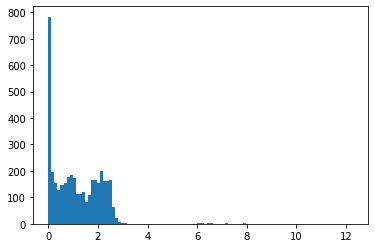

In [125]:
q = plt.hist(df.L, bins = 100)

In [126]:
emasks = []
masks = []
for msk in df.Mask.unique():
    if msk[:2] == 'e_':
        emasks.append(msk)
    elif msk != 'eue':
        masks.append(msk)
print(masks)
print(emasks)

['vanilla', 'mirror_random', 'decorrelating', 'decorrelating_sc', 'dpp', 'rank_dpp']
['e_vanilla', 'e_mirror_random', 'e_decorrelating', 'e_decorrelating_sc', 'e_dpp', 'e_rank_dpp']


In [127]:
df_temp = df[df.fname == 'bost_split=0_kfold=0_model=0.pickle']
from collections import Counter
Counter(df_temp.Mask)

Counter({'vanilla': 1,
         'mirror_random': 1,
         'decorrelating': 1,
         'decorrelating_sc': 1,
         'dpp': 1,
         'rank_dpp': 1,
         'eue': 1,
         'e_vanilla': 1,
         'e_mirror_random': 1,
         'e_decorrelating': 1,
         'e_decorrelating_sc': 1,
         'e_dpp': 1,
         'e_rank_dpp': 1})

In [128]:
# fname = 'kin8_split=0_kfold=1_model=1.pickle'


In [107]:
# http://abelsiqueira.github.io/blog/introduction-to-performance-profile/

In [108]:
# %%time
# large_data = []
# for fname, df_temp in df.groupby('fname'):
#     data = []
#     assert len(df_temp[df_temp.Mask == 'eue']) == 1
#     eue_performance = df_temp[df_temp.Mask == 'eue'][metric].values[0]
#     for ue_run in range(ue_runs):
#         dct_ens = {'eue': eue_performance}
#         for emask in emasks:
#             dct_ens[emask] = df_temp[df_temp.Mask == emask][metric].values[ue_run]
#         for ens_n in range(ens_num):
#             dct_single = dct_ens.copy()
#             for mask in masks:
#                 perf = df_temp[df_temp.Mask == mask][metric].values[ue_run::2][ens_n]
#                 dct_single[mask] = perf
# #             dct_single = {k: 1./v for k, v in dct_single.items()}
#             dct_single = {k: 1. - v for k, v in dct_single.items()}
#             data.append(dct_single)
    
#     df_res = pd.DataFrame(data)
#     normalized_values = df_res.values/df_res.min(axis = 1).values[:,None]
#     df_res = pd.DataFrame(normalized_values, columns = df_res.columns)
#     large_data.append(df_res)

In [129]:
%%time
metric = 'NDCG'
large_data = []
for fname, df_temp in df.groupby('fname'):
    data = []
    assert len(df_temp[df_temp.Mask == 'eue']) == 1
    eue_performance = df_temp[df_temp.Mask == 'eue'][metric].values[0]
    dct_single = {'eue': eue_performance}
    for emask in emasks:
        dct_single[emask] = df_temp[df_temp.Mask == emask][metric].values[0]
    for mask in masks:
        perf = df_temp[df_temp.Mask == mask][metric].values[0]
        dct_single[mask] = perf
#     dct_single = {k: 1. - v for k, v in dct_single.items()}
    dct_single = {k: 1./v for k, v in dct_single.items()}
    data.append(dct_single)
    
    df_res = pd.DataFrame(data)
    normalized_values = df_res.values/df_res.min(axis = 1).values[:,None]
    df_res = pd.DataFrame(normalized_values, columns = df_res.columns)
    large_data.append(df_res)

CPU times: user 2.2 s, sys: 1.73 ms, total: 2.2 s
Wall time: 2.2 s


In [130]:
df_res = pd.concat(large_data)

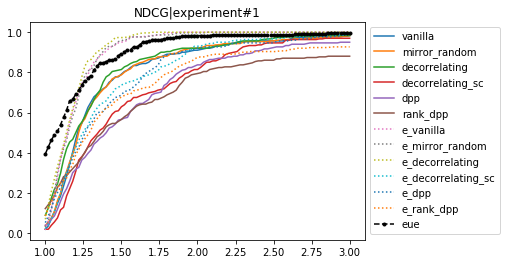

In [132]:
make_dm_plot(df_res, masks, emasks, metric, 'experiment#1', 
             taus = np.linspace(1, 3, 101),)
# make_dm_plot(df_res, masks, emasks, metric, 'experiment#1',
#              plotter = plt.semilogx, taus = 10**np.linspace(0, 4, 101),
#             )

In [113]:
np.max(np.ravel(df_res.values))

7.675909389384086e+60

In [16]:
def make_dm_plot(df_res, masks, emasks,
                 metric = 'some metric', 
                 exper = 'some exper',
                 taus = np.linspace(1, 3, 101),
                 plotter = plt.plot
                ):
    npp = len(df_res)
    for msk in masks:
        pas = []
        for tau in taus:
            pas.append(sum(df_res[msk].values <= tau)/npp)
        plotter(taus, pas, label = msk)
    for msk in emasks:
        pas = []
        for tau in taus:
            pas.append(sum(df_res[msk].values <= tau)/npp)
        plotter(taus, pas, ':', label = msk)
    pas = []
    for tau in taus:
        pas.append(sum(df_res['eue'].values <= tau)/npp)
    plotter(taus, pas, 'k.--', label = 'eue')


    plt.legend(bbox_to_anchor = (1,1))
    plt.title(metric + '|' + exper)

Text(0.5, 1.0, 'Acc')

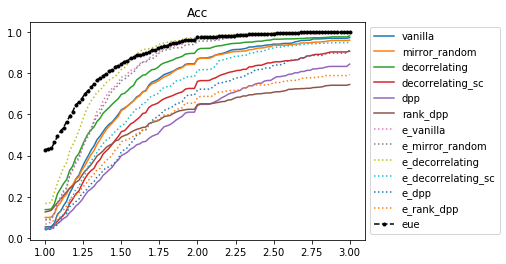

In [114]:

# taus = np.linspace(np.min(np.ravel(df_res.values)),
#                        1.,
#                        101
#                       )
taus = np.linspace(1, 3, 101)
for msk in masks:
    pas = []
    for tau in taus:
        pas.append(sum(df_res[msk].values <= tau)/npp)
    plt.plot(taus, pas, label = msk)
for msk in emasks:
    pas = []
    for tau in taus:
        pas.append(sum(df_res[msk].values <= tau)/npp)
    plt.plot(taus, pas, ':', label = msk)
pas = []
for tau in taus:
    pas.append(sum(df_res['eue'].values <= tau)/npp)
plt.plot(taus, pas, 'k.--', label = 'eue')
    

plt.legend(bbox_to_anchor = (1,1))
plt.title(metric)

Text(0.5, 1.0, 'NDCG')

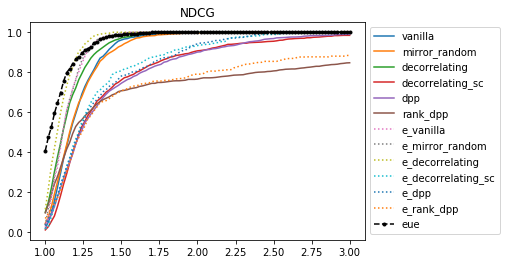

In [120]:
taus = np.linspace(1, 3, 101)
for msk in masks:
    pas = []
    for tau in taus:
        pas.append(sum(df_res[msk].values <= tau)/npp)
    plt.plot(taus, pas, label = msk)
for msk in emasks:
    pas = []
    for tau in taus:
        pas.append(sum(df_res[msk].values <= tau)/npp)
    plt.plot(taus, pas, ':', label = msk)
pas = []
for tau in taus:
    pas.append(sum(df_res['eue'].values <= tau)/npp)
plt.plot(taus, pas, 'k.--', label = 'eue')
    

plt.legend(bbox_to_anchor = (1,1))
plt.title(metric)

0.04033170832547953

Counter({'vanilla': 10,
         'mirror_random': 10,
         'decorrelating': 10,
         'decorrelating_sc': 10,
         'dpp': 10,
         'rank_dpp': 10,
         'eue': 1,
         'e_vanilla': 2,
         'e_mirror_random': 2,
         'e_decorrelating': 2,
         'e_decorrelating_sc': 2,
         'e_dpp': 2,
         'e_rank_dpp': 2})

,Acc,NDCG,LL,RMSE,Mask,Tag,fname
10494,0.189313,0.470429,-8.497557,0.085806,eue,standard,kin8_split=0_kfold=1_model=1.pickle


In [25]:
df_temp[df_temp.Mask == 'e_vanilla']

,Acc,NDCG,LL,RMSE,Mask,Tag,fname
10496,0.181679,0.481818,0.578349,0.085806,e_vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10497,0.174046,0.481997,0.577822,0.085806,e_vanilla,standard,kin8_split=0_kfold=1_model=1.pickle


In [26]:
df_temp[df_temp.Mask == 'vanilla']

,Acc,NDCG,LL,RMSE,Mask,Tag,fname
10434,0.175573,0.469137,0.364589,0.089682,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10435,0.160305,0.469613,0.374292,0.089682,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10446,0.158779,0.434590,0.386134,0.087393,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10447,0.152672,0.449703,0.394317,0.087393,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10458,0.187786,0.511399,0.352328,0.092787,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10459,0.192366,0.508211,0.352859,0.092787,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10470,0.149618,0.463355,0.368340,0.089283,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10471,0.146565,0.462362,0.371206,0.089283,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10482,0.146565,0.450750,0.205153,0.090757,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle
10483,0.152672,0.454942,0.207366,0.090757,vanilla,standard,kin8_split=0_kfold=1_model=1.pickle


In [287]:
import pickle
import os

In [288]:
fls = os.listdir('./exp1/')

'nava_split=1_kfold=4_model=0.pickle'

In [293]:
with open(f'./exp3/{np.random.choice(fls)}', 'rb') as f:
    dct = pickle.load(f)
dct['config']

{'nn_runs': 100,
 'runs': 2,
 'max_runs': 20,
 'verbose': False,
 'layers': [8, 128, 128, 64, 1],
 'epochs': 10000,
 'validation_step': 100,
 'nll_layers': [8, 256, 256, 128, 2],
 'nll_epochs': 400,
 'nll_validation_step': 50,
 'acc_percentile': 0.1,
 'patience': 10,
 'dropout_rate': 0.2,
 'dropout_uq': 0.5,
 'batch_size': 256,
 'dataset': 'kin8nm',
 'l2_reg': 1e-05,
 'ood_percentile': 90,
 'optimizer': {'type': 'Adam', 'lr': 0.01, 'weight_decay': 1e-05},
 'n_split_runs': 3,
 'n_model_runs': 3,
 'n_ens': 5,
 'n_ue_runs': 5,
 'k_folds': 10,
 'train_opts': {'epochs': 10000,
  'validation_step': 100,
  'patience': 10,
  'dropout_rate': 0.2,
  'batch_size': 256}}